# Running Facebook Prophet model for forecasting Eurostat *tour_occ_nim* monthly indicator

Facebook has just open sourced [`Prophet`](https://facebookincubator.github.io/prophet/), a forecasting project available in `Python`.

At its core, the `Prophet` procedure is an **additive regression model** with four main components (based on [`Stan`](http://mc-stan.org) Bayesian approach):
1. a piecewise linear (or logistic) growth curve trend: `Prophet` automatically detects changes in trends by selecting changepoints from the data,
2. a yearly seasonal component modeled using Fourier series,
3. a weekly seasonal component using dummy variables,
4. a user-provided list of important holidays.

We will (**blindly: we make no assumption whatsoever here**, beyond the obvious seasonality of the data) use the features 1. and 2. of the model to **build forecast estimates of Eurostat [*tour_occ_nim*](http://appsso.eurostat.ec.europa.eu/nui/show.do?dataset=tour_occ_nim&lang=en) monthly indicator for EU28 area**:

<img src="docs/tour_occ_nim_table.png">

We suppose here that all required packages have been already install (see `Prophet` original webpage for `Prophet`'s dependencies). Let us first import everything we need:

In [1]:
import os, sys
import requests
import pandas as pd
import numpy as np
from fbprophet import Prophet
# needed for display in notebook
%matplotlib notebook 
from matplotlib import pyplot as plt

We then need to retrieve the historical data of *tour_occ_nim* EU28 time-series that will be "fed" to the model. We will use [Eurostat REST API](http://ec.europa.eu/eurostat/web/json-and-unicode-web-services/getting-started/rest-request) for that purpose.

We first "configure" the API. Note that we will manipulate `json` data:   

In [2]:
PROTOCOL        = "http"
API_LANG        = "en"
API_FMT         = "json"
API_DOMAIN      = 'ec.europa.eu/eurostat/wdds'
API_VERS        = 2.1
API_URL         = "{}://{}/rest/data/v{}/{}/{}".format(
                  PROTOCOL, API_DOMAIN, API_VERS, API_FMT, API_LANG
                  )
print(API_URL)

http://ec.europa.eu/eurostat/wdds/rest/data/v2.1/json/en


We then define the specific time-series that we will consider through the following settings:

In [3]:
GEO             = "EU28"
# TIME : all
INDICATOR       = (u'tour_occ_nim', "Tour accomodation")
UNIT            = (u'NR', "Number of nights")
NACE_R2         = (u'I551', "Hotels; holiday and other short-stay accommodation...")
INDIC_TO        = (u'B006', "Nights spent, total")

We finally build the URL that we will submit to the REST API (see also [Eurostat query builder](http://ec.europa.eu/eurostat/web/json-and-unicode-web-services/getting-started/query-builder)):

In [4]:
url             = "{}/{}?geo={}&unit={}&nace_r2={}&indic_to={}".format(
                  API_URL, INDICATOR[0], GEO, UNIT[0], NACE_R2[0], INDIC_TO[0])
print(url)

http://ec.europa.eu/eurostat/wdds/rest/data/v2.1/json/en/tour_occ_nim?geo=EU28&unit=NR&nace_r2=I551&indic_to=B006


If you copy paste this URL in your browser as is, you can display the data as they are returned by the REST service, in [`jsonstat`](https://json-stat.org) format:

<img src="docs/tour_occ_nim_json.png">

Next, we want to store the data in a `pandas.DataFrame` object (since the input to `Prophet` is always a `pandas.DataFrame`). From here, it should be possible to perform this operation using any of  [`pyjstat`](https://pypi.python.org/pypi/pyjstat/) or [`jsonstat.py`](https://github.com/26fe/jsonstat.py) dedicated packages, _e.g._:
```python
collection = jsonstat.from_url(url)
tour_occ_nim = collection.dataset('tour_occ_nim')
df = tour_occ_nim.to_data_frame('year')
```
However, it seems that neither package currently works with `Python3`. 

Let us then do the job "manually". We submit the request directly to the REST service with the built URL: 

In [5]:
session = requests.session()
try:
    response = session.head(url)
    response.raise_for_status()
except:
    raise IOError("ERROR: wrong request formulated")  
else:
    print ("OK: status={}".format(response.status_code))
    
try:    
    response = session.get(url)
except:
    raise IOError('error retrieveing response from URL')

INFO:requests.packages.urllib3.connectionpool:Starting new HTTP connection (1): ec.europa.eu


OK: status=200


Once we have retrieved the response, we further extract/format the data of interest from the formatted `jsonstat` dictionary:

In [6]:
resp = response.json()
lbl2idx = resp['dimension']['time']['category']['index']
idx2lbl = {v:k for (k,v) in lbl2idx.items()}
data = resp['value']
data = {idx2lbl[int(k)]:v for (k,v) in data.items()}
table = {k.replace('M','-'):v for (k,v) in data.items()}

The table contains exactly the data we need, let us store it into a `pandas.DataFrame` object as desired. As already mentioned, the input to `Prophet` is always a `pandas.DataFrame` object, and it must contain two columns: `ds` and `y`. 

In [7]:
df = pd.DataFrame(list(table.items()), columns=['ds','y'])
# df = df[df['y'].notnull()] # Prophet can deal with NaN data!

We also sort the data "chronogically" (this is not really neede since the sorting is also done in `Prophet`, but it will be useful for plotting):

In [8]:
df.sort_values('ds', inplace=True)
ds_last = df['ds'].values[-1] # we keep that for later

Let us have a quick look at the data:

In [9]:
df.head()

,ds,y
18,2005-01,80813747
141,2005-02,87420210
5,2005-03,108217408
137,2005-04,103711903
128,2005-05,134257150


In [10]:
df.tail()

,ds,y
138,2016-07,237181783
109,2016-08,252210220
56,2016-09,193509848
7,2016-10,155886177
107,2016-11,103648347


Last, we further convert the `ds` column into `datetime` formatted values:

In [11]:
df['ds'] = pd.to_datetime(df['ds']) # note that this will add a day date
df.tail()

,ds,y
138,2016-07-01,237181783
109,2016-08-01,252210220
56,2016-09-01,193509848
7,2016-10-01,155886177
107,2016-11-01,103648347


Let us display the data (and check the seasonal nature of it):

<IPython.core.display.Javascript object>


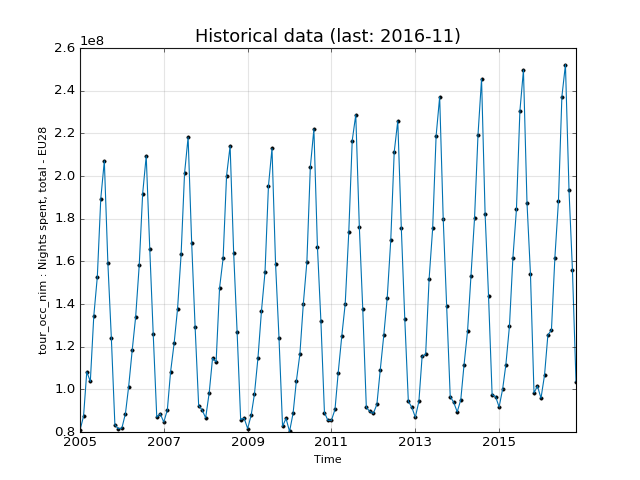

In [12]:
xlabel = "Time"
ylabel = "{} : {} - {}".format(INDICATOR[0], INDIC_TO[1], GEO)  
plt.plot(df['ds'], df['y'], 'k.')
plt.plot(df['ds'], df['y'], ls='-', c='#0072B2')
plt.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
plt.xlabel(xlabel, fontsize=10); plt.ylabel(ylabel, fontsize=10)
plt.title("Historical data (last: {})".format(ds_last), fontsize=16)
plt.show()

Considering the trend observed in the data, we define the regression model for `Prophet` by instantiating a new `Prophet` model as follows:

In [13]:
m = Prophet(growth = "linear", yearly_seasonality=True, weekly_seasonality=False)

We then call its `fit` method and pass in the historical dataframe built earlier:

In [14]:
m.fit(df)

We extend the data into the future by a specified number of days using the `make_future_dataframe` method. Say that we consider to predict the time-series over the 5 next years:

In [15]:
nyears = 5
future = m.make_future_dataframe(periods=12*nyears, freq='M')
fcst = m.predict(future)

That's how the forecast table looks like:

In [16]:
fcst[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
199,2021-07-31,2.663635e+08,2.587931e+08,2.734955e+08
200,2021-08-31,2.111388e+08,2.033173e+08,2.187629e+08
201,2021-09-30,1.762634e+08,1.685916e+08,1.836730e+08
202,2021-10-31,1.311676e+08,1.232626e+08,1.388206e+08
203,2021-11-30,1.303897e+08,1.219315e+08,1.381942e+08


Let us plot the forecast estimates calculated by the `Prophet` model:

<IPython.core.display.Javascript object>


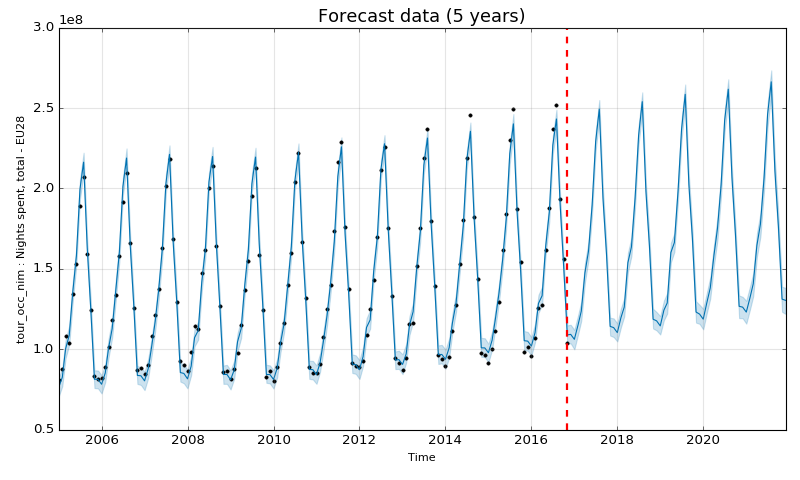

In [17]:
m.plot(fcst, uncertainty=True) 
plt.axvline(pd.to_datetime(ds_last), color='r', linestyle='--', lw=2)
plt.xlabel(xlabel, fontsize=10); plt.ylabel(ylabel, fontsize=10)
plt.title("Forecast data ({} years)".format(nyears), fontsize=16)

`Prophet` also provides with the components (overall trend and yearly profile) of the time-series:

<IPython.core.display.Javascript object>


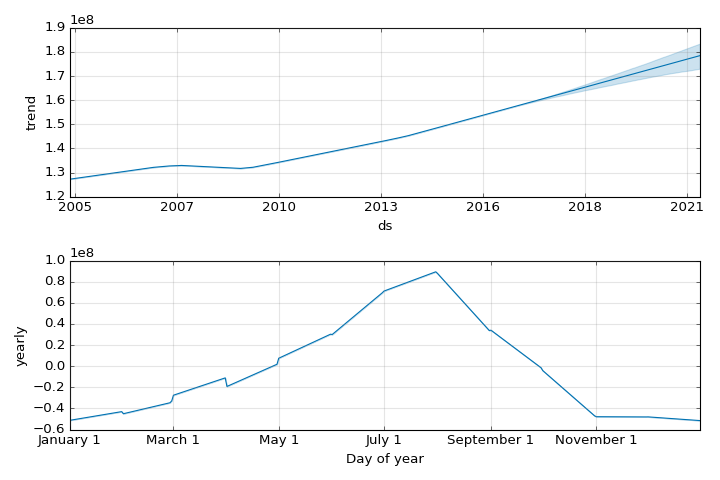

In [18]:
m.plot_components(fcst, uncertainty=True);
# plt.title("Forecast components", fontsize=16)

**What about other indicators?**